In [1]:
# Jason Qin
# 08/05/19

library(data.table)
library(stringr)
library(dplyr)
library(glmnet)
library(glmtlp)
library(tictoc)
library(tidyverse)
library(ggplot2)
library(reshape2)
library(NCmisc)
library(pryr)
library(seriation)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loading required package: foreach

Loaded glmnet 2.0-18


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1     ✔ readr   1.3.1
✔ tibble  2.1.3     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::between()    masks data.table::between()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::first()      masks data.table::first()
✖ dplyr::lag()        masks stats::lag()
✖ dplyr::last()       masks data.table::last()
✖ purrr::transpose()  

In [ ]:
# load previously-saved analysis
# save.image('/scratch/PI/horence/jason/data/single_cell/influenza_russell/analyzed/R_analysis/TS_smartseq_gene_exp.RData')
load('/scratch/PI/horence/jason/data/single_cell/influenza_russell/analyzed/R_analysis/TS_smartseq_gene_exp.RData')

In [ ]:
read1Files <- Sys.glob('/scratch/PI/horence/Roozbeh/single_cell_project/output/TS_pilot_smartseq_cSM_10_cJOM_10_aSJMN_0_cSRGM_0/*/1ReadsPerGene.out.tab')
read2Files <- Sys.glob('/scratch/PI/horence/Roozbeh/single_cell_project/output/TS_pilot_smartseq_cSM_10_cJOM_10_aSJMN_0_cSRGM_0/*/2ReadsPerGene.out.tab')

In [ ]:
## Read data from appropriate directories
read1Data <- lapply(read1Files, read.csv, header=TRUE, sep='\t')

# filter out files that have no reads and mess up downstream analysis
read1Data <- read1Data[-298]
read1Data <- read1Data[-804]
read1Files <- read1Files[-298]
read1Files <- read1Files[-804]
read2Data <- lapply(read2Files, read.csv, header=TRUE, skip=3, sep='\t')

In [19]:
# Establish which genes should be included in analysis
transacting.gene.names <- c('QKI', 'NF90', 'NF110', 'DHX9', 'FUS', 'HNRNP', 'SFR', 'ADAR', 'RNU')

In [20]:
### organize HTSeq Read1 Expression matrix
read1Mat <- do.call(cbind, read1Data)
read1Mat.genes <- as.character(unlist(read1Mat[5]))
read1Mat.genes[361] <- 'MATR3.2' # handle duplicate gene name
rownames(read1Mat) <- read1Mat.genes
read1Mat <- read1Mat[colnames(read1Mat) == 'V2']

In [21]:
# parse file names
read1Files.split <- strsplit(read1Files, '/')
read1Files.split <- do.call(rbind, read1Files.split)
read1Cells <- read1Files.split[, 9]
colnames(read1Mat) <- read1Cells

In [22]:
##### Process mmquant data
mmquantPrefix <- '/scratch/PI/horence/jason/data/tabula_sapiens/smartseq_mmquant/'
mmquantFiles <- paste0(mmquantPrefix, read1Cells, '.tsv')
mmquantData <- lapply(mmquantFiles, read_delim, col_names=TRUE, delim='\t', col_types=c(col_character(), col_integer()))

In [3]:
# Convert mmquant list of expression into expression matrix
mmquantGenes <- unique(unlist(mmquantData))
mmquantModelGenesDetected <- sapply(mmquantGenes, function(x) {
    return(any(str_detect(x, transacting.gene.names)))
})

mmquantModelGenes <- mmquantGenes[mmquantModelGenesDetected]
mmquantMat <- mmquantData[[1]]
for (i in c(2:length(mmquantData))) {
    mmquantMat <- full_join(mmquantMat[unlist(mmquantMat['Gene']) %in% mmquantModelGenes, ], mmquantData[[i]][unlist(mmquantData[[i]]['Gene']) %in% mmquantModelGenes, ], by='Gene')
}
mmquantMat[is.na(mmquantMat)] <- 0

In [4]:
# fix duplicate named gene 'U1--U1--RNU1-59P--U1'
mmquantMat[175, 'Gene'] <- paste(mmquantMat[175, 'Gene'], '--2')

In [5]:
# Reorganize mmquant expression matrix
mmquantMat <- as.data.frame(mmquantMat)
rownames(mmquantMat) <- unlist(mmquantMat['Gene'])
mmquantMat <- mmquantMat[, -1]
colnames(mmquantMat) <- read1Cells
mmquantMat[!(sapply(mmquantMat, is.numeric))] <- 0

In [7]:
rowSums(mmquantMat > 0)

HNRNPA0 
                                                                                                                                                                                  100 
                                                                                                                                                                           HNRNPA1P47 
                                                                                                                                                                                    3 
                                                                                                                                                                              HNRNPH1 
                                                                                                                                                                                  342 
                                                                                                                                                                               HNRNPR 
                                                                                                                                                                                  174 
                                                                                                                                                                       HNRNPR--ZNF765 
                                                                                                                                                                                    7 
                                                                                                                                                                  RP11-11N7.5--HNRNPU 
                                                                                                                                                                                  190 
                                                                                                                                                                               HNRNPF 
                                                                                                                                                                                  172 
                                                                                                                                                                   AC104534.3--HNRNPL 
                                                                                                                                                                                  306 
                                                                                                                                                                                 ADAR 
                                                                                                                                                                                  161 
                                                                                                                                                                        ATF3--HNRNPH1 
                                                                                                                                                                                  286 
                                             AXDND1--HNRNPA1P54--RP11-968A15.8--HNRNPA1--HNRNPA1L2--GAREM--AC021224.1--HNRNPA1P7--ZNF833P--HNRNPA1P10--FAM126B--HNRNPA1P35--HNRNPA1P4 
                                                                                                                                                                                  139 
                                                                                                                                                    

In [14]:
# identify which multimapped genes are similar to each other
mmquantModelGenesSplit <- lapply(mmquantModelGenes, str_split, '--')
mmquantModelGenesSplit <- lapply(mmquantModelGenesSplit, function(x) { 
    return(lapply(x, function(y) {
        geneMatches <- sapply(y, function(z) {
            return(any(str_detect(z, transacting.gene.names)))
        })
        return(y[geneMatches])
    }))
})

commonTransactingGenes <- unique(unlist(mmquantModelGenesSplit))
mapToCommonTransactingGenes <- suppressWarnings(lapply(mmquantModelGenesSplit, function(x) {
    geneMatches <- match(unlist(x), commonTransactingGenes)
    return((geneMatches))
}))
commonTransactingGenesCounts <- table(unlist(mapToCommonTransactingGenes))
commonTransactingGenesCountsOrdered <- order(-commonTransactingGenesCounts)
commonTransactingGenesCounts <- commonTransactingGenesCounts[commonTransactingGenesCountsOrdered]

mapToCommonTransactingGenesOrdered <- sapply(mapToCommonTransactingGenes, function(x) {
    return(min(match(x, as.numeric(names(commonTransactingGenesCounts)))))
})

In [18]:
# some ad-hoc confirmation that things are working
(mapToCommonTransactingGenesOrdered)
mmquantModelGenesSplit[1696]

[1] 1699

[[1]]
[[1]][[1]]
[1] "RNU6-6P"  "RNU6-36P" "RNU6-1"   "RNU6-2"   "RNU6-5P"  "RNU6-42P"

In [19]:
# combine similar multimapped genes together
mmquantMatCollapsed <- t(sapply(1:length(commonTransactingGenes), function(i) {
    return(colSums(mmquantMat[mapToCommonTransactingGenesOrdered == i, ]))
}))
rownames(mmquantMatCollapsed) <- commonTransactingGenes

In [20]:
# some more ad-hoc sanity checks

# commonTransactingGenes
# rownames(mmquantMat)[str_detect(rownames(mmquantMat), 'RNU4ATAC')]
# rowSums(read1Mat)[str_detect(rownames(read1Mat), 'RNU4ATAC')]
# str_detect(mmquantModelGenesSplit, 'RNU4ATAC')
rowSums(mmquantMatCollapsed)

HNRNPA0     HNRNPA1P47        HNRNPH1         HNRNPR         HNRNPU 
        317223           1421          12730            297         300696 
        HNRNPF         HNRNPL           ADAR     HNRNPA1P54        HNRNPA1 
           120            911         318083          84423              5 
     HNRNPA1L2      HNRNPA1P7     HNRNPA1P10     HNRNPA1P35      HNRNPA1P4 
             8            413            204          67648             17 
HNRNPUL2-BSCL2     HNRNPU-AS1     HNRNPA1P30     HNRNPA1P48        HNRNPAB 
         27985          22577          45950              1           8186 
        HNRNPK       HNRNPKP2       HNRNPKP4       HNRNPLP2         HNRNPM 
         46188         104452          14374         134741           2565 
RPL36A-HNRNPH2     HNRNPA1P12      HNRNPA1P8     HNRNPA1P39         ADARB2 
         55367             34         313437              3           5683 
    HNRNPA1P33     HNRNPA1P15     HNRNPA1P67     HNRNPA1P55      HNRNPA1P6 
             1            141            152              0              1 
    HNRNPA1P50     HNRNPA1P57          SFRP4            FUS      HNRNPA2B1 
            32              0              0             35              0 
       HNRNPA3      HNRNPA3P3      HNRNPA3P6         HNRNPC       HNRNPCP2 
             0          34152              1         150520         184255 
      HNRNPCL1         HNRNPD        HNRNPDL       HNRNPKP1        HNRNPLL 
             0              2              0              0              0 
      HNRNPUL1       HNRNPUL2       HNRNPUP1     HNRNPA1P26        RNU5B-1 
            43              3          34878          69368          49691 
        RNU1-1         RNU1-3         RNU1-4         RNU1-2       RNU1-27P 
          9266              3             10             40            637 
      RNU1-28P          RNU11        RNU5D-1        RNU6-6P         RNU6-7 
            74          11703              0           4794             39 
        RNU6-8         RNU6-1         RNU6-9         RNU6-2        RNU6-5P 
             1              1              0              0              5 
       RNU6-4P        RNU6-3P          ZNF90      HNRNPA1P1     HNRNPA1P44 
            92              0              1              0              2 
    HNRNPA1P28     HNRNPA3P10          SFRP1          SFRP5       HNRNPCP3 
             1         147389          31927            305              9 
    HNRNPA1P51           DHX9         DHX9P1      HNRNPABP1        HNRNPH2 
            13          43341            119              1              0 
       HNRNPH3       HNRNPRP1     HNRNPA1P25       RNU1-59P            QKI 
             1            132              0              0              0 
         RNU12     HNRNPA1P36      RNU1-125P       RNU2-63P      RNU6-433P 
         71634             24              4              2          36414 
    HNRNPA1P23         ADARB1       HNRNPKP3     HNRNPA1P18      RNU6-866P 
        164486         146210         187915            968             21 
     HNRNPA3P4      HNRNPA3P5       HNRNPCP4       HNRNPCP1      RNU6-190P 
             1              1             35              1              0 
        RNU4-1     HNRNPA1P42       RNU2-10P       RNU6-36P       RNU6-33P 
            49              2              1              1            474 
      RNU6-42P     HNRNPA1P52     HNRNPA1P41      RNU6-733P        RNU5A-1 
             1             26            202          29574              1 
      RNU5E-6P        RNU5E-1        RNU2-2P       RNU2-68P       HNRNPLP1 
             1              5            654            305              0 
         SFRP2       RNU4ATAC     RNU6-1216P      HNRNPDLP2     HNRNPA1P20 
             0           5021             36              3              4 
      HNRNPMP2       RNU2-27P     RNU6-1083P      RNU6-476P      RNU6-151P 
             0             21             77              3           7600 
    HNRNPA1P21           SFR1       HNRNPDP1        RNU

In [13]:
# Filter mmquant expression matrix and mmquant collapsed expression matrix
mmquantModelGenesFiltered <- mmquantModelGenes[rowSums(mmquantMat > 0) > 10]
mmquantMatFiltered <- mmquantMat[mmquantModelGenesFiltered, ]

mmquantCollapsedModelGenesFiltered <- commonTransactingGenes[rowSums(mmquantMatCollapsed > 0) > 10]
mmquantMatCollapsedFiltered <- mmquantMatCollapsed[mmquantCollapsedModelGenesFiltered, ]

In [24]:
rowSums(mmquantMatCollapsed[mmquantCollapsedModelGenesFiltered, ] > 0)

HNRNPA0     HNRNPA1P47        HNRNPH1         HNRNPR         HNRNPU 
           283            161            201             66            237 
        HNRNPF         HNRNPL           ADAR     HNRNPA1P54      HNRNPA1P7 
            62            138            304            198             45 
    HNRNPA1P10     HNRNPA1P35      HNRNPA1P4 HNRNPUL2-BSCL2     HNRNPU-AS1 
            28            283             16            190            266 
    HNRNPA1P30        HNRNPAB         HNRNPK       HNRNPKP2       HNRNPKP4 
           202            103            176            201            266 
      HNRNPLP2         HNRNPM RPL36A-HNRNPH2     HNRNPA1P12      HNRNPA1P8 
           116            101            121             26            343 
        ADARB2     HNRNPA1P15     HNRNPA1P67     HNRNPA1P50      HNRNPA3P3 
           128             31             32             16            135 
        HNRNPC       HNRNPCP2       HNRNPUL1       HNRNPUP1     HNRNPA1P26 
           176            263             34            311            166 
       RNU5B-1         RNU1-1         RNU1-2       RNU1-27P       RNU1-28P 
           136            127             13             94             35 
         RNU11        RNU6-6P         RNU6-7     HNRNPA3P10          SFRP1 
           106             39             12            258            108 
         SFRP5           DHX9         DHX9P1       HNRNPRP1          RNU12 
            15            143             14             21            123 
     RNU6-433P     HNRNPA1P23         ADARB1       HNRNPKP3     HNRNPA1P18 
           150            254            208            260             11 
      HNRNPCP4      RNU6-733P        RNU2-2P       RNU2-68P       RNU4ATAC 
            29            113             67             11             11 
    RNU6-1216P       RNU2-27P     RNU6-1083P      RNU6-151P       RNU4-46P 
            13             14             34             20            101 
     RNU6-701P      RNU6-977P     RNU6-1024P      RNU6-946P      HNRNPA1P5 
            26             43            146             16             41 
       RNU1-5P      RNU6-942P      RNU6-450P       HNRNPCL3       HNRNPCL4 
           188             14             31             25             57 
     HNRNPH1P3     RNU6-1203P       HNRNPCP9     HNRNPA1P71 
            13             54             15             11

In [23]:
# filter HTSeq data to only include transacting factor genes
transacting.factors <- read1Mat.genes[str_detect(read1Mat.genes, transacting.gene.names)]
transacting.factor.expression <- read1Mat[transacting.factors, ]
transacting.factors.filtered <- transacting.factors[rowSums(read1Mat[transacting.factors, ]) > 10]
# rowSums(transacting.factor.expression)

Warning message in stri_detect_regex(string, pattern, negate = negate, opts_regex = opts(pattern)):
“longer object length is not a multiple of shorter object length”


In [9]:
## choose best junctions to use as response variable for GLM
# filter junctions based on expression
class.input.data <- fread('/scratch/PI/horence/jason/data/tabula_sapiens/splicing_detection.tsv', sep='\t', header=TRUE)
colnames(class.input.data) <- c('acceptor', 'donor', 'num_splice_events')
class.input.data <- class.input.data[order(acceptor)]
class.input.data <- class.input.data[num_splice_events > 10]

In [10]:
# function for choosing which junctions to include in the GLM
isoform_filter <- function(data) {
    genes <- unlist(data[, 'acceptor'])
        
    genes <- table(genes)
    genes.filtered <- genes[genes > 1]
    genes.filtered <- data.table(genes.filtered)

    filtered.data <- inner_join(data, genes.filtered, by=c('acceptor' = 'genes'))
        
    filtered.data <- data.table(filtered.data)
    return(filtered.data)
}

In [11]:
# do some spot checks
filtered.class.input.data <- isoform_filter(class.input.data)
filtered.class.input.data <- filtered.class.input.data[order(-num_splice_events)]
head(filtered.class.input.data)

acceptor,donor,num_splice_events,N
<chr>,<chr>,<int>,<int>
"chr8_SNORA70,Metazoa_SRP,Y_RNA,SFTPC_22163080","chr8_SNORA70,Metazoa_SRP,Y_RNA,SFTPC_22162732",2054647,2
"chrX_Metazoa_SRP,Y_RNA,SNORA31,TMSB4X_12976246","chrX_Metazoa_SRP,Y_RNA,SNORA31,TMSB4X_12975168",903099,3
"chr8_SNORA70,Metazoa_SRP,Y_RNA,SFTPC_22164266","chr8_SNORA70,Metazoa_SRP,Y_RNA,SFTPC_22164059",877069,3
"chr11_H19_3,Y_RNA,Metazoa_SRP,SNORA7,snoU13,SNORA1,SCGB1A1,CTD-2531D15.4_62422221","chr11_H19_3,Y_RNA,Metazoa_SRP,SNORA7,snoU13,SNORA1,SCGB1A1_62419150",866377,2
"chr11_H19_3,Y_RNA,Metazoa_SRP,SNORA7,snoU13,SNORA1,BEST1,FTH1_61965369","chr11_H19_3,Y_RNA,Metazoa_SRP,SNORA7,snoU13,SNORA1,BEST1,FTH1_61965112",566338,2
"chr11_H19_3,Y_RNA,Metazoa_SRP,SNORA7,snoU13,SNORA1,FTH1_61967312","chr11_H19_3,Y_RNA,Metazoa_SRP,SNORA7,snoU13,SNORA1,BEST1,FTH1_61965515",471205,3


In [ ]:
# write.table(filtered.class.input.data, file='/scratch/PI/horence/jason/data/tabula_sapiens/TS_smartseq_filtered_junctions.tsv', quote=FALSE, sep='\t')

 chr [1:473] "B107809_A11_S131" "B107809_A12_S132" "B107809_A13_S133" ...


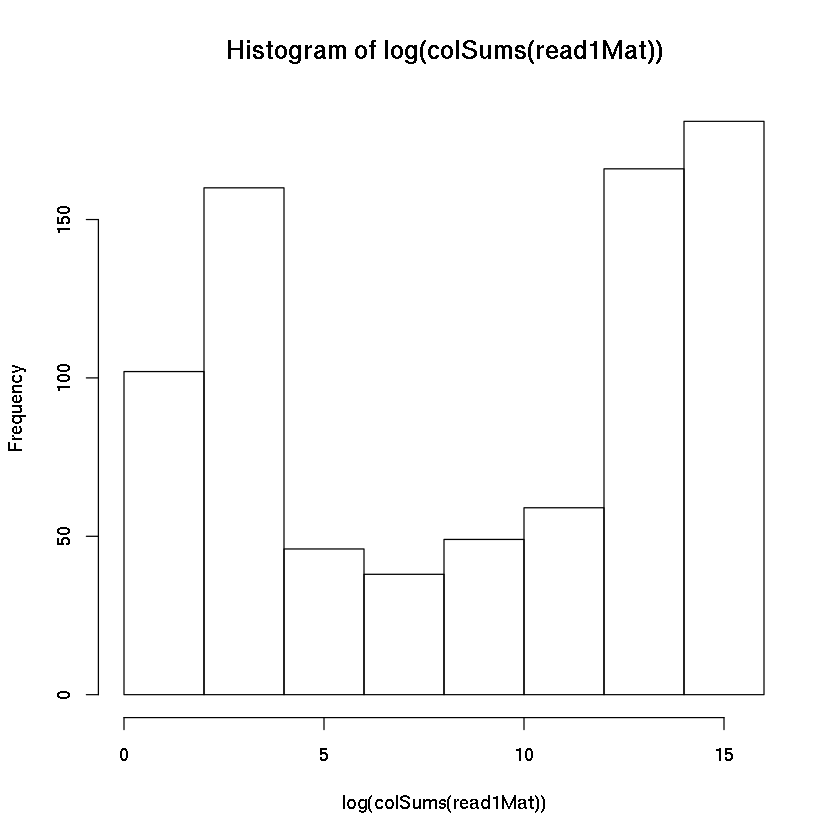

In [4]:
# choose cells with sufficient expression levels for downstream modeling (filter determined with HTSeq data)
hist(log(colSums(read1Mat)))
read1Mat.filtered <- read1Mat[, log(colSums(read1Mat)) > 7] # filter cells below expression threshold
str(colnames(read1Mat.filtered))

In [13]:
## read class input files
filtered.cells <- colnames(read1Mat.filtered)
# filtered.cells.paths.prefix <- '/scratch/PI/horence/Roozbeh/single_cell_project/output/TS_pilot_smartseq_cSM_10_cJOM_10_aSJMN_0_cSRGM_0'
# filtered.cells.class.input.paths <- outer(filtered.cells.paths.prefix, filtered.cells, paste, sep='/')
# filtered.cells.class.input.paths <- outer(filtered.cells.class.input.paths, 'class_input_WithinBAM.tsv', paste, sep='/')

filtered.cells.paths.prefix <- '/scratch/PI/horence/jason/data/tabula_sapiens/smartseq_class_input'
filtered.cells.class.input.paths <- outer(filtered.cells.paths.prefix, filtered.cells, paste, sep='/')
filtered.cells.class.input.paths <- outer(filtered.cells.class.input.paths, '.tsv', paste, sep='')
filtered.cells.class.input.exists <- file.exists(filtered.cells.class.input.paths)
filtered.cells.class.input.paths <- filtered.cells.class.input.paths[filtered.cells.class.input.exists]

class.input.data <- lapply(filtered.cells.class.input.paths, fread, header=TRUE, sep='\t', colClasses=c('character', 'character', 'numeric'))
class.input.data <- c(list(filtered.class.input.data), class.input.data)
class.input.data <- class.input.data %>% reduce(left_join, by = c('acceptor', 'donor'))

In [5]:
# Filter expression from HTSeq data for cells that have class input files that exist
read1Mat.filtered <- read1Mat.filtered[filtered.cells.class.input.exists]
filtered.cells.subset <- filtered.cells[filtered.cells.class.input.exists]
colnames(class.input.data)[5:ncol(class.input.data)] <- filtered.cells.subset

In [ ]:
# Fix NA's in class input expression file, and filter out junctions detected in fewer than 40 cells total
class.input.data[is.na(class.input.data)] <- 0
class.input.data.subset <- class.input.data[rowSums(class.input.data[5:ncol(class.input.data)] > 0) > 150, ]
str(class.input.data.subset)

In [3]:
# split all expression matrices into train and test data
test.cells <- sample(filtered.cells.subset, 70)
train.cells <- setdiff(filtered.cells.subset, test.cells)

testRead1MatData <- read1Mat.filtered[colnames(read1Mat.filtered) %in% test.cells]
trainRead1MatData <- read1Mat.filtered[colnames(read1Mat.filtered) %in% train.cells]

testmmquantMatData <- mmquantMat[colnames(mmquantMat) %in% test.cells]
trainmmquantMatData <- mmquantMat[colnames(mmquantMat) %in% train.cells]

testmmquantMatFilteredData <- mmquantMatFiltered[colnames(mmquantMat) %in% test.cells]
trainmmquantMatFilteredData <- mmquantMatFiltered[colnames(mmquantMat) %in% train.cells]

testmmquantMatCollapsedData <- mmquantMatCollapsed[, colnames(mmquantMatCollapsed) %in% test.cells]
trainmmquantMatCollapsedData <- mmquantMatCollapsed[, colnames(mmquantMatCollapsed) %in% train.cells]

testmmquantMatCollapsedFilteredData <- mmquantMatCollapsedFiltered[, colnames(mmquantMatCollapsed) %in% test.cells]
trainmmquantMatCollapsedFilteredData <- mmquantMatCollapsedFiltered[, colnames(mmquantMatCollapsed) %in% train.cells]

testClassInputData <- class.input.data.subset[colnames(class.input.data) %in% test.cells]
trainClassInputData <- class.input.data.subset[colnames(class.input.data) %in% train.cells]

In [65]:
rowSums(trainmmquantMatCollapsedFilteredData > 0)
rowSums(trainClassInputData > 0)

HNRNPA0     HNRNPA1P47        HNRNPH1         HNRNPR         HNRNPU 
           231            126            161             49            198 
        HNRNPF         HNRNPL           ADAR     HNRNPA1P54      HNRNPA1P7 
            48            109            246            165             34 
    HNRNPA1P10     HNRNPA1P35      HNRNPA1P4 HNRNPUL2-BSCL2     HNRNPU-AS1 
            21            234             11            163            223 
    HNRNPA1P30        HNRNPAB         HNRNPK       HNRNPKP2       HNRNPKP4 
           167             82            143            168            219 
      HNRNPLP2         HNRNPM RPL36A-HNRNPH2     HNRNPA1P12      HNRNPA1P8 
            98             83             99             20            282 
        ADARB2     HNRNPA1P15     HNRNPA1P67     HNRNPA1P50      HNRNPA3P3 
           101             22             26             12            111 
        HNRNPC       HNRNPCP2       HNRNPUL1       HNRNPUP1     HNRNPA1P26 
           147            219             25            260            133 
       RNU5B-1         RNU1-1         RNU1-2       RNU1-27P       RNU1-28P 
           116            104             11             80             32 
         RNU11        RNU6-6P         RNU6-7     HNRNPA3P10          SFRP1 
            85             30              9            213             91 
         SFRP5           DHX9         DHX9P1       HNRNPRP1          RNU12 
            12            116             11             15             93 
     RNU6-433P     HNRNPA1P23         ADARB1       HNRNPKP3     HNRNPA1P18 
           125            205            171            219              9 
      HNRNPCP4      RNU6-733P        RNU2-2P       RNU2-68P       RNU4ATAC 
            22             91             51              8              7 
    RNU6-1216P       RNU2-27P     RNU6-1083P      RNU6-151P       RNU4-46P 
            11             10             28             15             88 
     RNU6-701P      RNU6-977P     RNU6-1024P      RNU6-946P      HNRNPA1P5 
            21             34            122             15             38 
       RNU1-5P      RNU6-942P      RNU6-450P       HNRNPCL3       HNRNPCL4 
           157             12             26             23             48 
     HNRNPH1P3     RNU6-1203P       HNRNPCP9     HNRNPA1P71 
            10             45             13              7

2    5    6    8    9   11   12   14   15   18   21   22   23   24   25   26 
 293  264  261  177  291  177  174  175  255  242  233  258  200  183  248  267 
  27   28   29   30   31   32   33   34   36   37   39   40   41   42   43   44 
 167  213  229  183  187  174  168  272  239  243  200  194  243  230  256  203 
  45   46   47   48   50   51   52   53   54   55   56   57   59   60   64   65 
 224  212  123  188  152  175  184  177  243  162  219  221  204  169  223  185 
  66   67   68   69   70   71   72   73   74   75   77   78   79   80   81   82 
 176  257  176  170  232  183  229  123  216  124  237  174  207  168  146  245 
  84   85   88   89   93   96   98  100  102  106  107  108  109  110  112  113 
 181  195  201  193  183  195  197  152  166  181  233  125  177  127  187  166 
 114  116  117  118  121  122  124  125  126  127  128  130  131  132  141  142 
 174  223  215  151  190  180  141  184  214  191  180  131  121  156  135  157 
 143  144  146  150  151  152  155  158  159  162  163  164  165  166  171  177 
 168  206  165  190  197  134  206  141  138  177  136  141  205  159  150  147 
 178  182  186  187  188  190  192  193  195  197  201  206  207  208  210  213 
 125  144  121  209  131  145  191  140  148  191  181  132  127  128  137  145 
 214  215  216  218  221  223  226  231  233  234  235  236  238  241  242  243 
 177  147  158  126  254  163  202  146  200  146  144  181  143  131  122  154 
 245  247  248  253  255  256  258  260  265  266  269  270  272  273  280  281 
 139  231  120  184  124  162  134  156  231  150  153  128  163  128  137  122 
 282  297  306  329  330  338  342  356  359  367  369  380  385  399  406  410 
 127  179  127  129  169  127  136  134  124  140  163  133  133  127  158  190 
 420  440  442  468  471  543  602  618  624  626  645  699  826  836 1110 1129 
 132  127  128  121  152  121  130  128  141  172  136  146  127  137  141  149 
1589 1625 1913 2440 2971 3509 4924 
 185  136  154  151  137  131  123

In [64]:
# spot check expression of transacting factors in HTSeq data
testRead1TransactingData <- testRead1MatData[transacting.factors.filtered, ]
trainRead1TransactingData <- trainRead1MatData[transacting.factors.filtered, ]

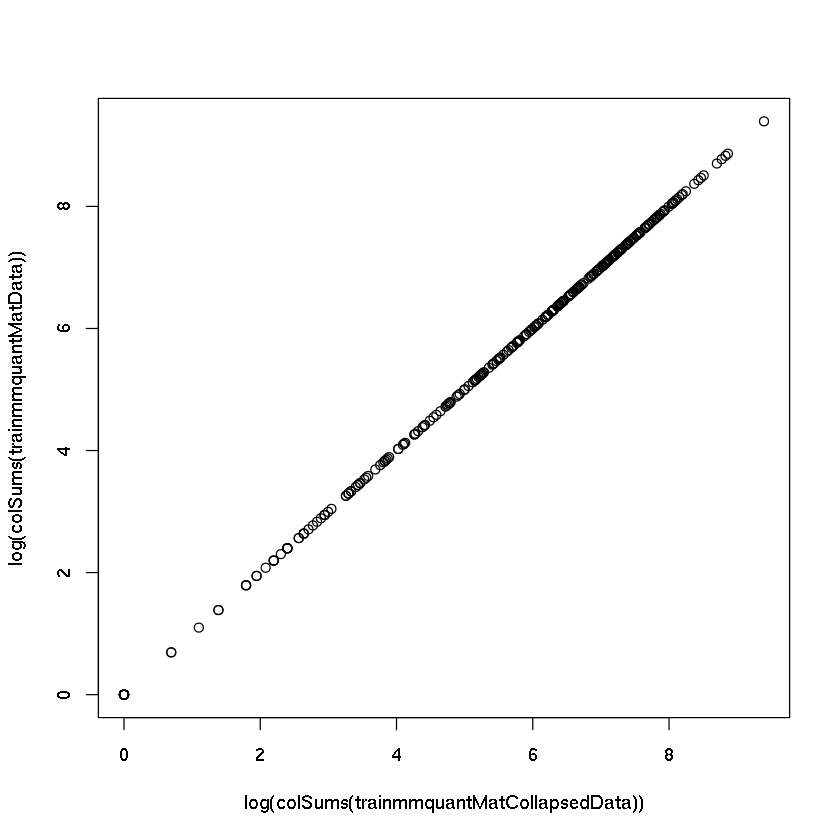

In [32]:
# spot check differences between how many reads each cell has depending on which aligner is used
# head(trainmmquantMatData)
# plot(log(colSums(trainmmquantMatCollapsedData)), log(colSums(trainRead1TransactingData)))
plot(log(colSums(trainmmquantMatCollapsedData)), log(colSums(trainmmquantMatData)))
# match(colnames(trainmmquantMatData), colnames(trainRead1TransactingData))


 num [1:79, 1:401] 0 0 0 0 0 0 0 0 95 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:79] "HNRNPA0" "HNRNPA1P47" "HNRNPH1" "HNRNPR" ...
  ..$ : chr [1:401] "B107809_A11_S131" "B107809_A13_S133" "B107809_A16_S136" "B107809_A18_S138" ...
'data.frame':	199 obs. of  401 variables:
 $ B107809_A11_S131: num  193 0 0 0 6 0 0 0 0 0 ...
 $ B107809_A13_S133: num  586 173 148 7 374 10 10 9 527 293 ...
 $ B107809_A16_S136: num  2196 2144 1754 3672 180 ...
 $ B107809_A18_S138: num  559 0 0 0 112 0 0 0 0 0 ...
 $ B107809_A2_S122 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ B107809_A5_S125 : num  7 0 0 0 0 0 0 0 0 0 ...
 $ B107809_A6_S126 : num  1396 454 426 0 33 ...
 $ B107809_A9_S129 : num  0 0 0 0 78 0 0 0 0 0 ...
 $ B107809_B10_S153: num  1627 269 213 150 1984 ...
 $ B107809_B11_S154: num  1076 1071 890 2148 172 ...
 $ B107809_B12_S155: num  3658 515 461 349 1441 ...
 $ B107809_B17_S160: num  629 364 378 16 1293 ...
 $ B107809_B18_S161: num  1561 529 488 1161 339 ...
 $ B107809_B19_S162: num  0 827 80

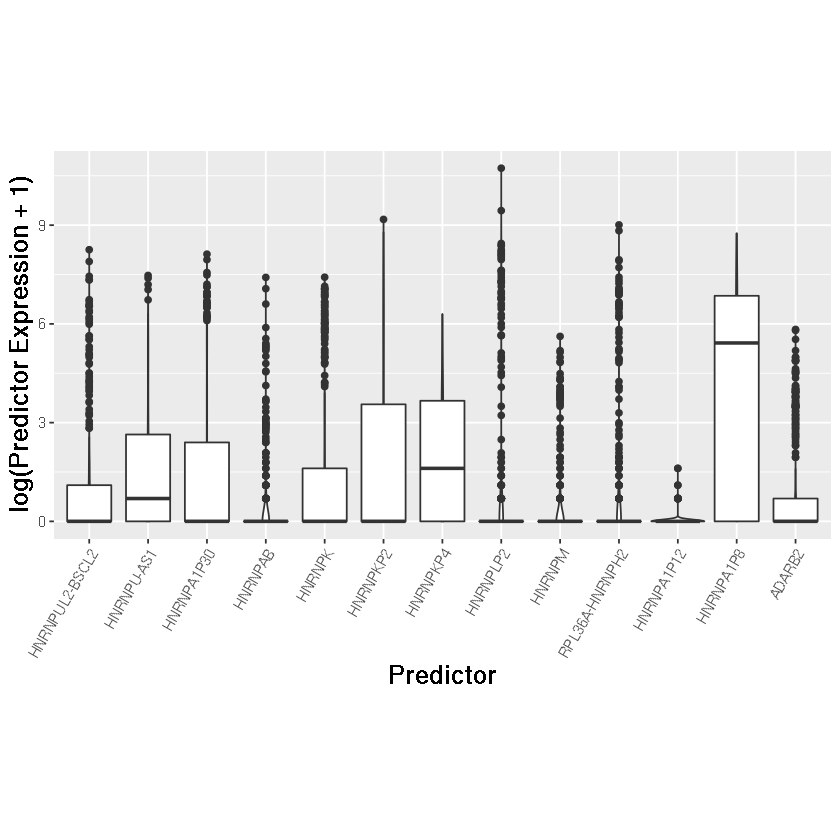

In [11]:
# plot the distribution of transacting factor reads among cells

# start by analyzing the HTseq-quantified reads
# plotData1 <- (melt(as.matrix(trainRead1TransactingData[1:13, ])))
# plotData2 <- (melt(as.matrix(trainRead1TransactingData[14:26, ])))
# plotData3 <- (melt(as.matrix(trainRead1TransactingData[21:26, ])))

# next, analyze mmquant-assigned reads
# plotData2 <- (melt(as.matrix(trainmmquantMatData[14:26, ])))

# lastly, analyze collapsed mmquant-assigned reads
plotData2 <- (melt(as.matrix(trainmmquantMatCollapsedFilteredData[14:26, ])))

colnames(plotData2) = c('Genes', 'Cells', 'Expression')
p <- ggplot(plotData2, aes(x=Genes, y=log(Expression+1))) + geom_violin() + geom_boxplot() + 
    theme(axis.title=element_text(size=15,face="bold"), axis.text.x = element_text(angle = 60, hjust = 1), aspect.ratio=0.5) +
    xlab('Predictor') + ylab('log(Predictor Expression + 1)')
p
str(trainmmquantMatCollapsedFilteredData)
str(trainClassInputData)

In [6]:
# make plotting function for predictions vs. actual counts
compare_predictions_plot <- function(predictions, knownExp, title) {
    predsStacked <- melt(t(predictions))
    dataStacked <- melt(knownExp)
    dataToPlot <- cbind(predsStacked, dataStacked)
    colnames(dataToPlot) <- c('Junction', 'Cell1', 'Prediction', 'Cell2', 'Count')
    
    # what happens if we filter out 0 counts?
    # dataToPlot <- dataToPlot[dataToPlot['Count'] > 0, ]
    
    alpha <- 1 / length(unlist(knownExp)) * 2000
    comparisonPlot <- ggplot(dataToPlot, aes(x=log(Count+1), y=log(Prediction+1))) + geom_point(alpha=0.05) + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black")) + ggtitle(title) + xlab('log(Actual Junction Count + 1)') + 
        ylab('log(Predicted Junction Count + 1)') + theme(plot.title=element_text(size=21, face='bold'), axis.text=element_text(size=14), axis.title=element_text(size=18,face="bold")) +
        ylim(0, NA) + xlim(0, NA)
    fitCor <- (cor(log(dataToPlot['Prediction'] + 1), log(dataToPlot['Count'] + 1)))
    fitCorFiltered <- (cor(log(dataToPlot['Prediction'][dataToPlot['Count'] > 0] + 1), log(dataToPlot['Count'][dataToPlot['Count'] > 0] + 1)))
    print(fitCorFiltered)
    comparisonPlot <- comparisonPlot + geom_abline(slope=1, intercept=0, linetype=2, size=1.5) + geom_text(x = 5, y = 8, label = (paste0('r = ', round(fitCor, 2))), size=7.5)
    return(comparisonPlot)
}

In [6]:
# general function for GLM training
train_glm <- function(juncExp, trainPredictorExp, testPredictorExp, numExamples=20) {
    trainPreds <- numeric()
    testPreds <- numeric()
    # for (i in c(1:nrow(trainClassInputData))) {
    for (i in c(1:numExamples)) { 
        glmData <- t(rbind(unlist(juncExp[i, ]), t(trainPredictorExp)))
        colnames(glmData)[1] <- 'junction'
        colnames(glmData) <- str_replace_all(colnames(glmData), '-', '_')
        glmData <- data.frame(glmData)
        regressionFormula <- paste(colnames(glmData)[2:length(colnames(glmData))], collapse='+')
        regressionFormula <- as.formula(paste0("junction ~ ", regressionFormula))
        glmModel <- glm(regressionFormula, family = poisson(), data=glmData)

        # evaluate model against training data
        glmModelTrainPred <- predict(glmModel, newdata=glmData, type='response')
        trainPreds <- cbind(trainPreds, glmModelTrainPred)

        # evaluate model against test data
        glmPredData <- unlist(testPredictorExp)
        colnames(glmPredData) <- str_replace_all(colnames(glmPredData), '-', '_')
        glmPredData <- as.data.frame(glmPredData)
        glmModelPred <- predict(glmModel, newdata=glmPredData, type='response')
        testPreds <- cbind(testPreds, glmModelPred)
    }
    return(list(trainPreds=trainPreds, testPreds=testPreds))
}

In [8]:
# general function for GLMNet training
# test GLMnet on mmquant data
train_glmnet <- function(juncExp, trainPredictorExp, testPredictorExp, numExamples=20) {
    trainPreds <- numeric()
    testPreds <- numeric()
    # for (i in c(1:nrow(trainClassInputData))) {
    for (i in c(1:numExamples)) {

        glmPred <- trainPredictorExp
        glmResponse <- unlist(juncExp[i, ])
        glmModel <- glmnet(glmPred, glmResponse, family = 'poisson')
        
        # what are the values of the fit parameters?
        print(coef(glmModel, s=10))

        # evaluate model against training data
        glmModelTrainPred <- predict(glmModel, newx=glmPred, type='response', s=10)
        trainPreds <- cbind(trainPreds, glmModelTrainPred)

        # evaluate model against test data
        glmPredData <- unlist(testPredictorExp)
        colnames(glmPredData) <- str_replace_all(colnames(glmPredData), '-', '_')
        glmModelPred <- predict(glmModel, newx=glmPredData, type='response', s=10)

        testPreds <- cbind(testPreds, glmModelPred)
    }
    return(list(trainPreds=trainPreds, testPreds=testPreds))
}

In [41]:
head(trainmmquantMatFilteredData)

,B107809_A11_S131,B107809_A13_S133,B107809_A16_S136,B107809_A18_S138,B107809_A2_S122,B107809_A5_S125,B107809_A6_S126,B107809_A9_S129,B107809_B10_S153,B107809_B11_S154,⋯,B107811_C18_S264,B107811_C19_S265,B107811_C1_S247,B107811_C22_S268,B107811_C3_S249,B107811_C4_S250,B107817_H15_S244,B107827_C18_S202,B107830_F9_S176,B107921_N5_S272
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HNRNPA0,1,20,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,90,0
HNRNPH1,4,181,3204,10,0,0,97,0,158,1227,⋯,0,530,1,0,0,0,0,0,2299,0
HNRNPR,94,0,1128,0,0,1,681,0,0,0,⋯,0,0,0,0,4,0,0,0,246,0
RP11-11N7.5--HNRNPU,3,69,128,702,0,0,0,0,0,6,⋯,0,150,0,0,0,0,0,0,270,0
HNRNPF,0,0,0,76,0,0,0,0,61,631,⋯,0,1142,0,0,0,0,0,0,743,0
AC104534.3--HNRNPL,0,69,27,31,0,28,0,0,25,72,⋯,0,5,0,0,0,0,0,0,9,22


In [9]:
# train GLM on all relevant data sets
HTSeqPredOutputGLM <- train_glm(trainClassInputData, t(trainRead1TransactingData), t(testRead1TransactingData), 20)
mmquantFilteredPredOutputGLM <- train_glm(trainClassInputData, t(trainmmquantMatFilteredData), t(testmmquantMatFilteredData), 20)
mmquantCollapsedFilteredPredOutputGLM <- train_glm(trainClassInputData, t(trainmmquantMatCollapsedFilteredData), t(testmmquantMatCollapsedFilteredData), 20)

# train GLMNet on all relevant data sets
HTSeqPredOutputGLMNet <- train_glmnet(trainClassInputData, t(trainRead1TransactingData), t(testRead1TransactingData), 20)
mmquantFilteredPredOutputGLMNet <- train_glmnet(trainClassInputData, t(trainmmquantMatFilteredData), t(testmmquantMatFilteredData), 20)
mmquantCollapsedFilteredPredOutputGLMNet <- train_glmnet(trainClassInputData, t(trainmmquantMatCollapsedFilteredData), t(testmmquantMatCollapsedFilteredData), 20)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted rates numerically 0 occurred”

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in

27 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  7.421703e+00
SFRP1       -6.656465e-04
SFRP2       -7.598894e-05
RNU6-766P   -7.096698e-02
RNU5F-1      1.534707e-02
RNU6-951P   -2.019478e-02
RNU5D-1     -6.196852e-04
RNU6-522P   -9.611570e-04
RNU6-60P     9.112399e-02
RNU4-2      -1.754281e-04
RNU6-946P   -3.489895e-05
RNU6-427P   -5.352634e-02
RNU6-611P   -3.668015e-02
RNU6-1026P   .           
RNU6-1127P   1.124280e-01
RNU6-748P   -2.404584e-04
RNU2-59P     1.198553e-01
RNU6-1203P   8.485314e-03
HNRNPRP1    -1.679113e-01
HNRNPKP4     2.649195e-03
HNRNPKP1     1.948160e-02
RNU7-40P     2.023679e-02
RNU1-103P    .           
RNU6-807P   -2.400716e-02
RNU5A-3P     1.308047e-01
RNU4ATAC    -3.937992e-03
RNU6-6P      1.092561e-02
27 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  6.900697e+00
SFRP1        1.417002e-04
SFRP2       -2.793113e-05
RNU6-766P   -4.724061e-02
RNU5F-1      1.658163e-02
RNU6-951P    .           
RNU5D-

213 x 1 sparse Matrix of class "dgCMatrix"
                                                                                                                                                                                         1
(Intercept)                                                                                                                                                                   6.253109e+00
HNRNPA0                                                                                                                                                                       .           
HNRNPH1                                                                                                                                                                       6.385685e-07
HNRNPR                                                                                                                                                                       -1.131388e-05
RP11-11N7.5--HNRNPU   

80 x 1 sparse Matrix of class "dgCMatrix"
                           1
(Intercept)     6.465887e+00
HNRNPA0         1.894394e-04
HNRNPA1P47      .           
HNRNPH1        -5.365132e-03
HNRNPR          2.522455e-03
HNRNPU         -5.947765e-05
HNRNPF         -5.914527e-02
HNRNPL          .           
ADAR            1.692356e-04
HNRNPA1P54     -1.635356e-04
HNRNPA1P7      -1.866637e-02
HNRNPA1P10     -8.471593e-03
HNRNPA1P35      6.404109e-04
HNRNPA1P4      -7.223516e-02
HNRNPUL2-BSCL2  6.538068e-05
HNRNPU-AS1      6.899041e-04
HNRNPA1P30      3.363505e-04
HNRNPAB         1.073800e-04
HNRNPK          1.841868e-04
HNRNPKP2        1.539042e-04
HNRNPKP4        3.945307e-03
HNRNPLP2        1.060589e-05
HNRNPM          3.320929e-03
RPL36A-HNRNPH2 -6.446141e-05
HNRNPA1P12     -5.813306e-02
HNRNPA1P8       1.264529e-04
ADARB2         -4.500633e-04
HNRNPA1P15     -1.928044e-02
HNRNPA1P67     -1.074842e-02
HNRNPA1P50      1.988493e-01
HNRNPA3P3      -1.933543e-04
HNRNPC          1.858467e-04
H

Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”


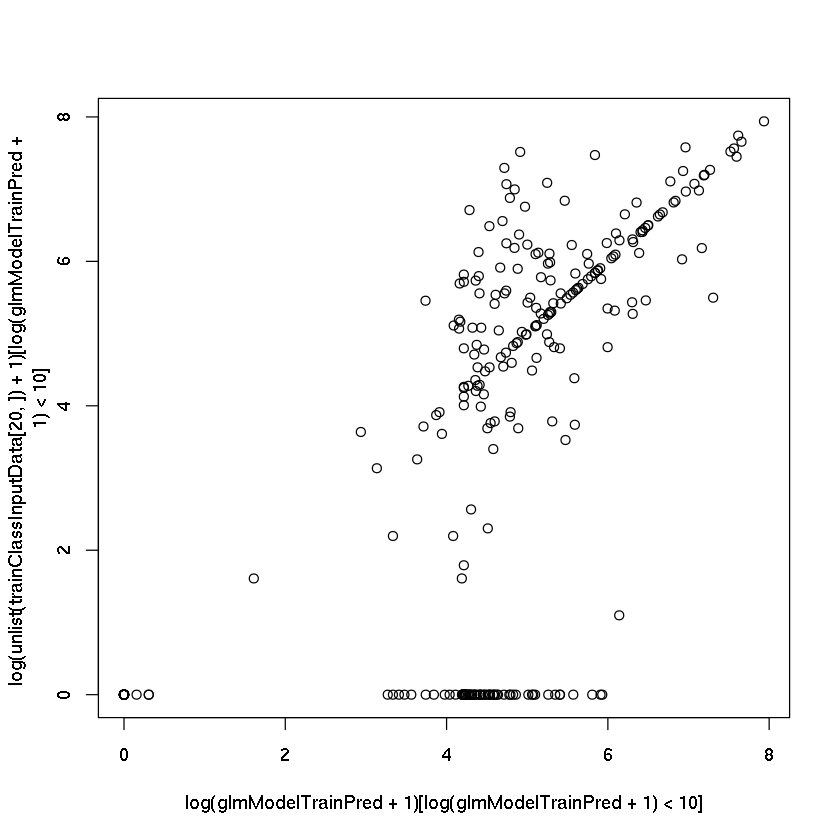

In [84]:
# see how model performs on permuted (i.e. random) data
glmData <- t(rbind(trainClassInputData[20, ], trainmmquantMatData))
colnames(glmData)[1] <- 'junction'
colnames(glmData) <- str_replace_all(colnames(glmData), '-', '_')
glmData <- data.frame(glmData)
regressionFormula <- paste(colnames(glmData)[2:length(colnames(glmData))], collapse='+')
regressionFormula <- as.formula(paste0("junction ~ ", regressionFormula))
glmDataPerm <- glmData
# colSums(glmDataPerm)
glmDataPerm[, 2:ncol(glmDataPerm)] <- sample(glmDataPerm[, 2:ncol(glmDataPerm)], replace=FALSE)
# colSums(glmDataPerm)

# glmDataPerm[, 2:ncol(glmDataPerm)] <- glmDataPerm[, sample(2:ncol(glmDataPerm))]
glmModel <- glm(regressionFormula, family = poisson(), data=glmDataPerm)
glmModelTrainPred <- predict(glmModel, newdata=glmDataPerm, type='response')
plot(log(glmModelTrainPred + 1)[log(glmModelTrainPred + 1) < 10], log(unlist(trainClassInputData[20, ]) + 1)[log(glmModelTrainPred + 1) < 10])

No id variables; using all as measure variables



[1] 0.4095555


No id variables; using all as measure variables



[1] 0.8509347


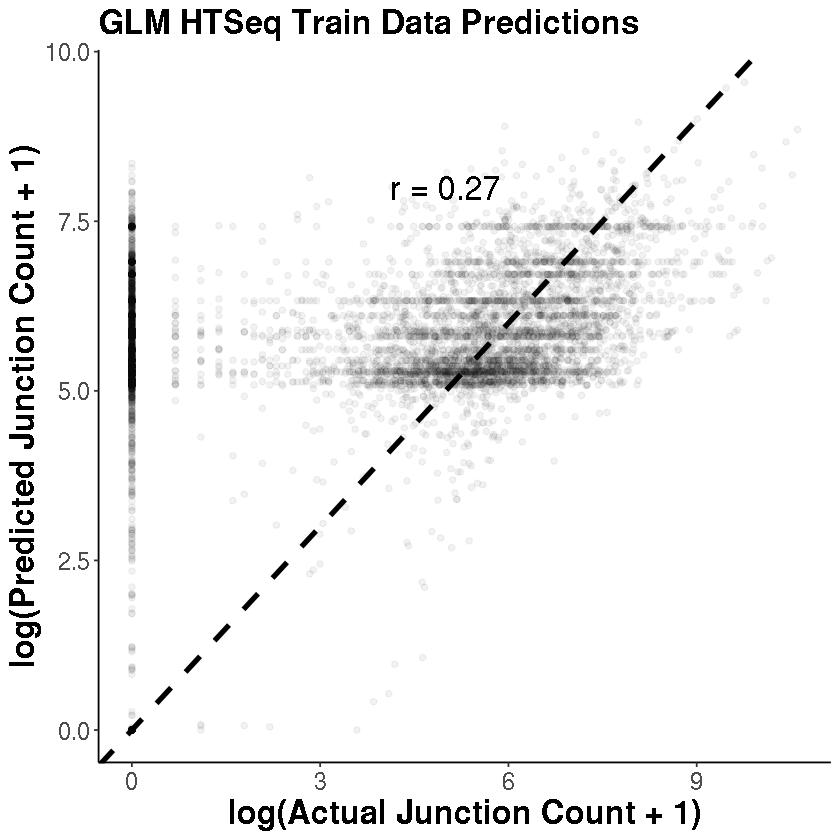

No id variables; using all as measure variables



[1] 0.6755134


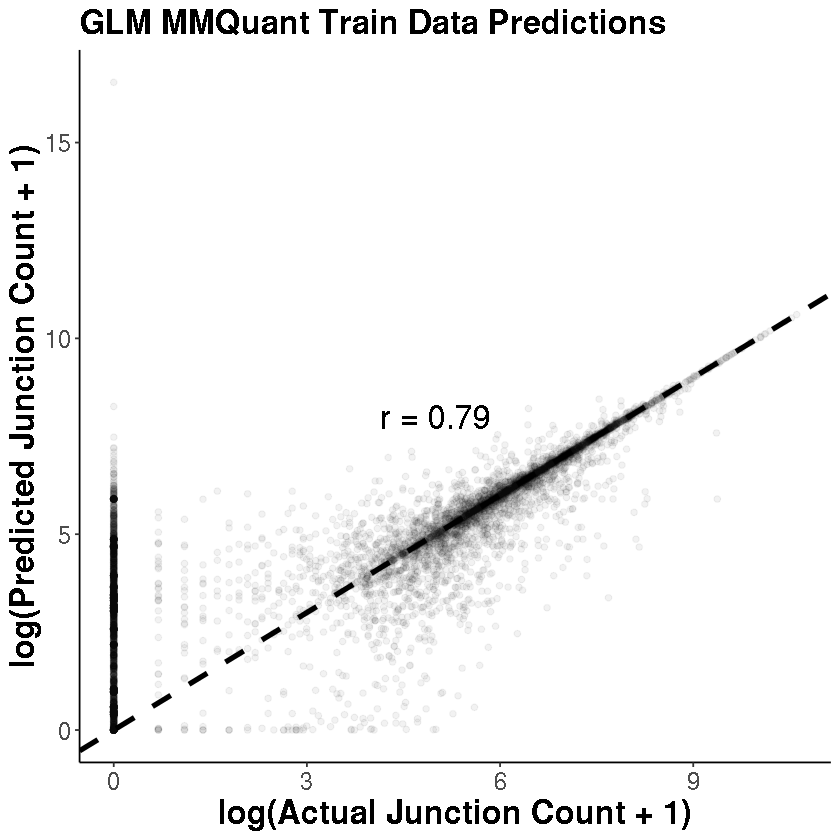

No id variables; using all as measure variables



[1] 0.3890741


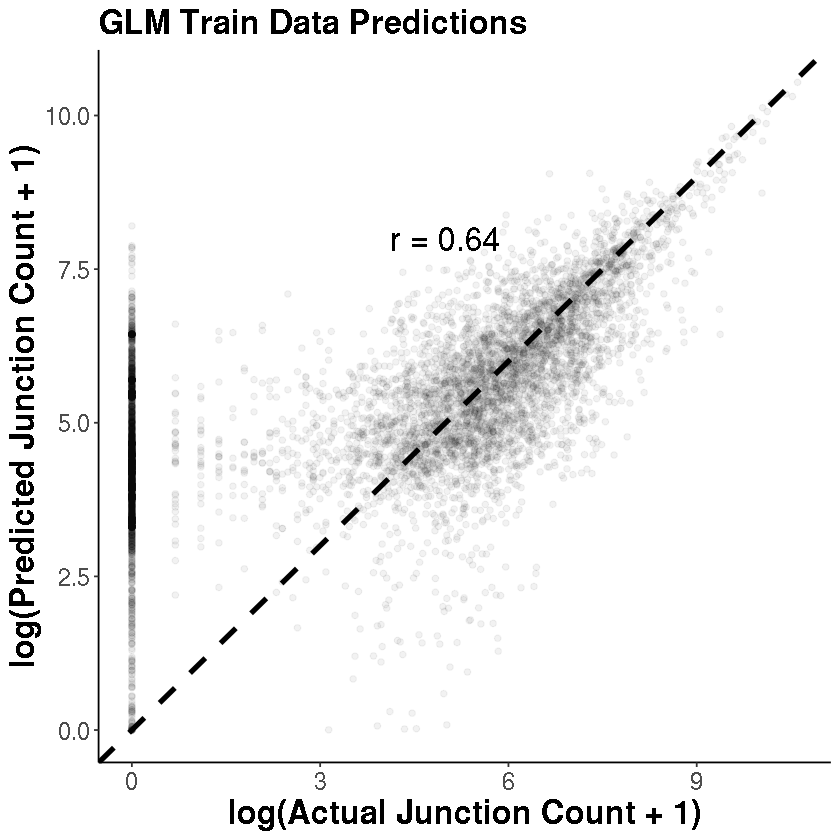

No id variables; using all as measure variables



[1] 0.737421


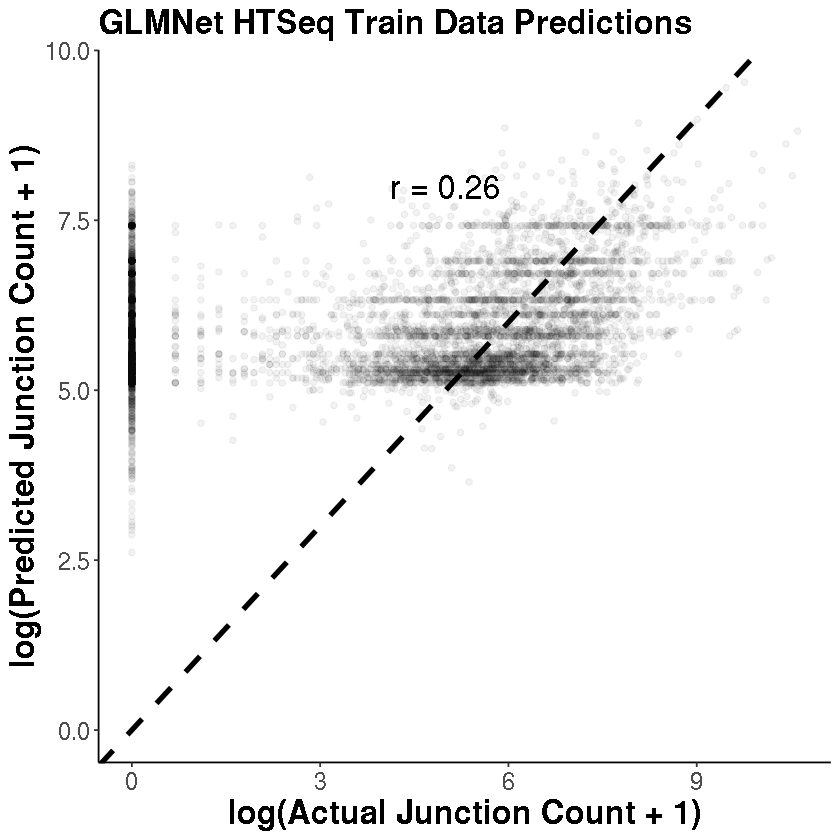

No id variables; using all as measure variables



[1] 0.6676513


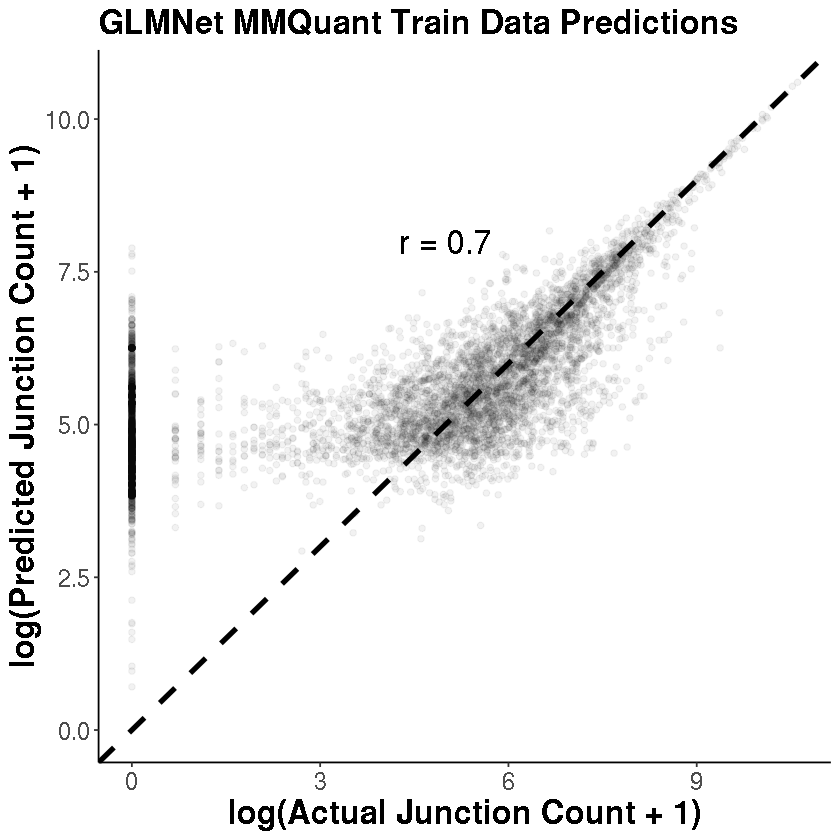

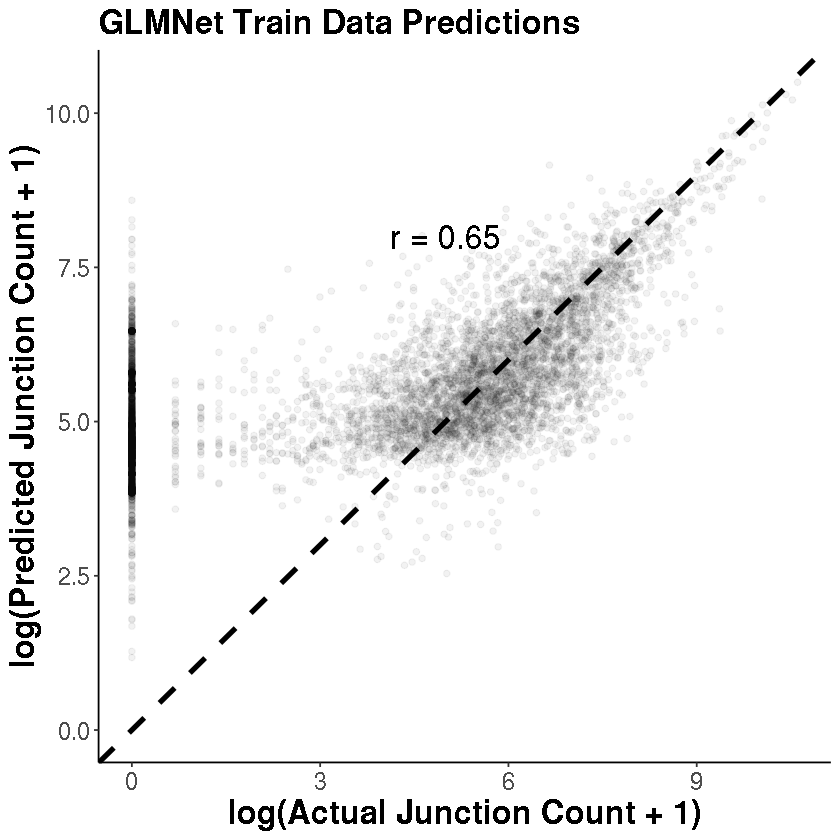

In [7]:
# plot predictions to actual counts for training data
compare_predictions_plot(HTSeqPredOutputGLM[['trainPreds']], trainClassInputData[1:20, ], 'GLM HTSeq Train Data Predictions')
compare_predictions_plot(mmquantFilteredPredOutputGLM[['trainPreds']], trainClassInputData[1:20, ], 'GLM MMQuant Train Data Predictions')
compare_predictions_plot(mmquantCollapsedFilteredPredOutputGLM[['trainPreds']], trainClassInputData[1:20, ], 'GLM Train Data Predictions')
# compare_predictions_plot(mmquantCollapsedFilteredPredOutputGLM[['trainPreds']], trainClassInputData[1:20, ], 'GLM MMQuantCollapsed Train Data Predictions')

compare_predictions_plot(HTSeqPredOutputGLMNet[['trainPreds']], trainClassInputData[1:20, ], 'GLMNet HTSeq Train Data Predictions')
compare_predictions_plot(mmquantFilteredPredOutputGLMNet[['trainPreds']], trainClassInputData[1:20, ], 'GLMNet MMQuant Train Data Predictions')
compare_predictions_plot(mmquantCollapsedFilteredPredOutputGLMNet[['trainPreds']], trainClassInputData[1:20, ], 'GLMNet Train Data Predictions')
# compare_predictions_plot(mmquantCollapsedFilteredPredOutputGLM[['trainPreds']], trainClassInputData[1:20, ], 'GLMNet MMQuantCollapsed Train Data Predictions')

No id variables; using all as measure variables



[1] 0.1519337


No id variables; using all as measure variables



[1] 0.2083012


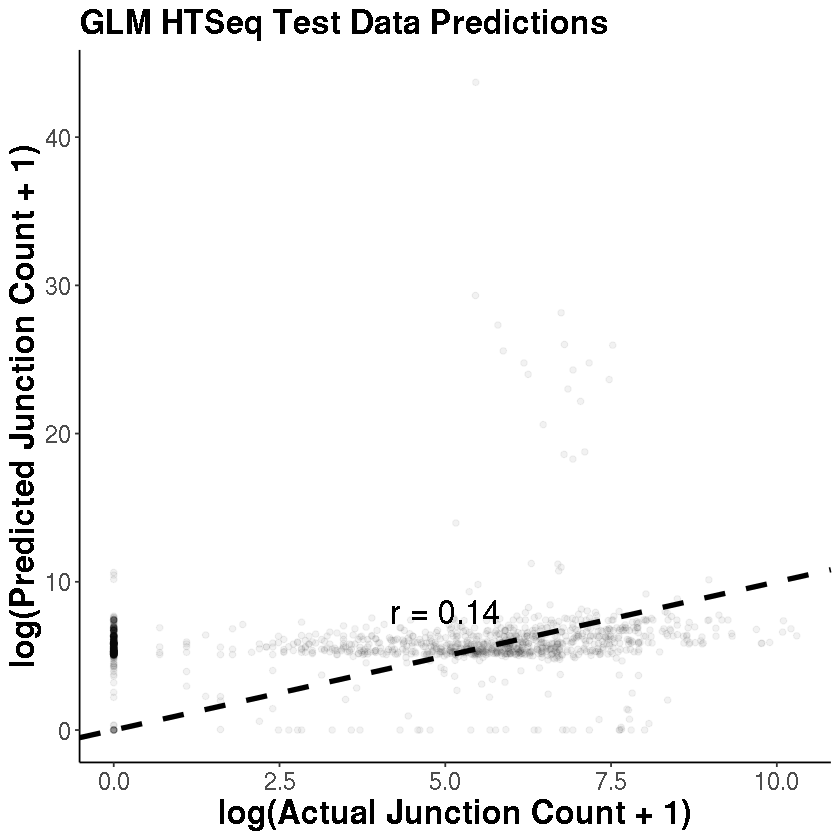

No id variables; using all as measure variables



[1] 0.3757277


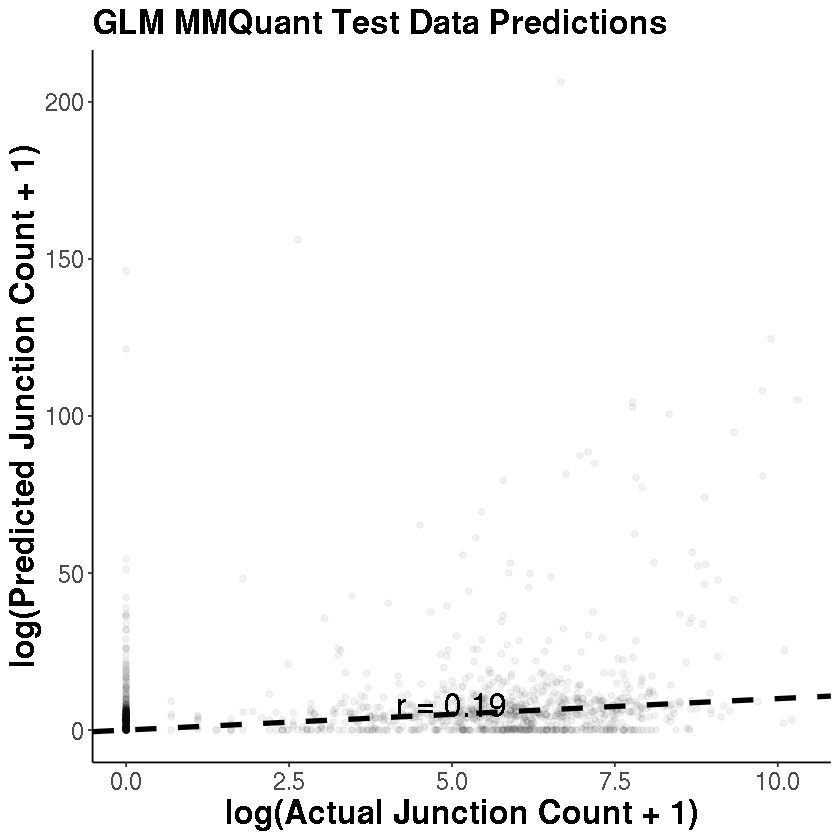

No id variables; using all as measure variables



[1] 0.1427854


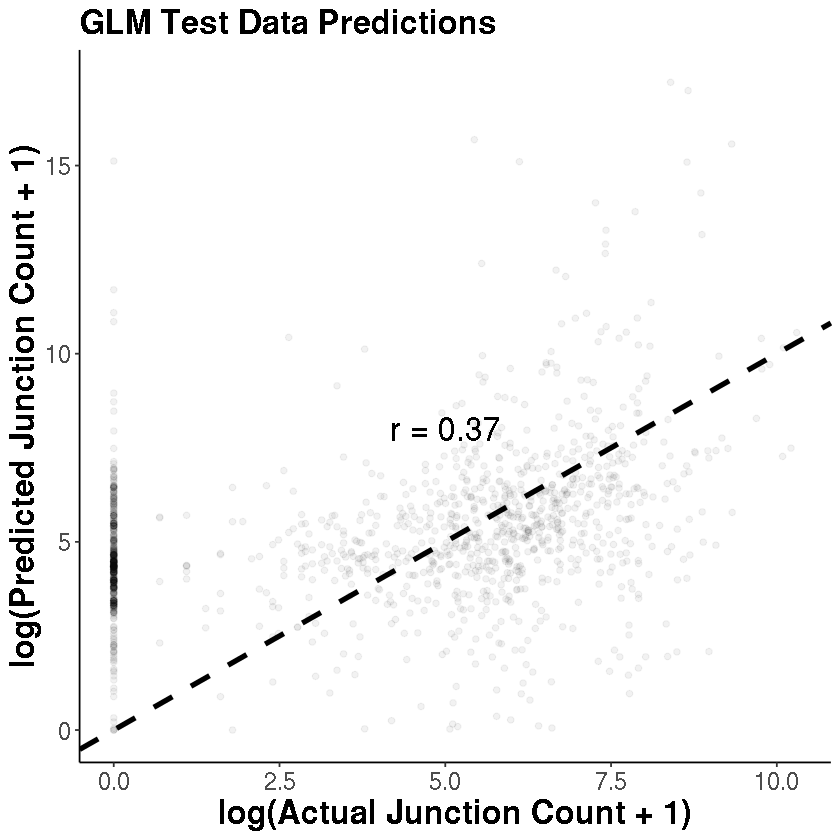

No id variables; using all as measure variables



[1] 0.4942539


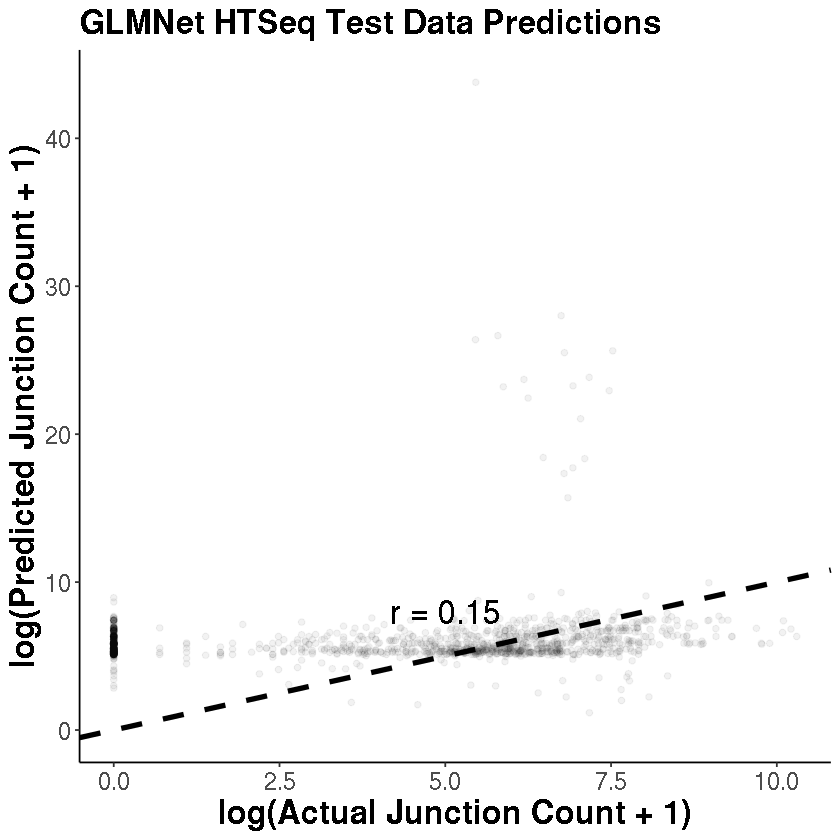

No id variables; using all as measure variables



[1] 0.5050858


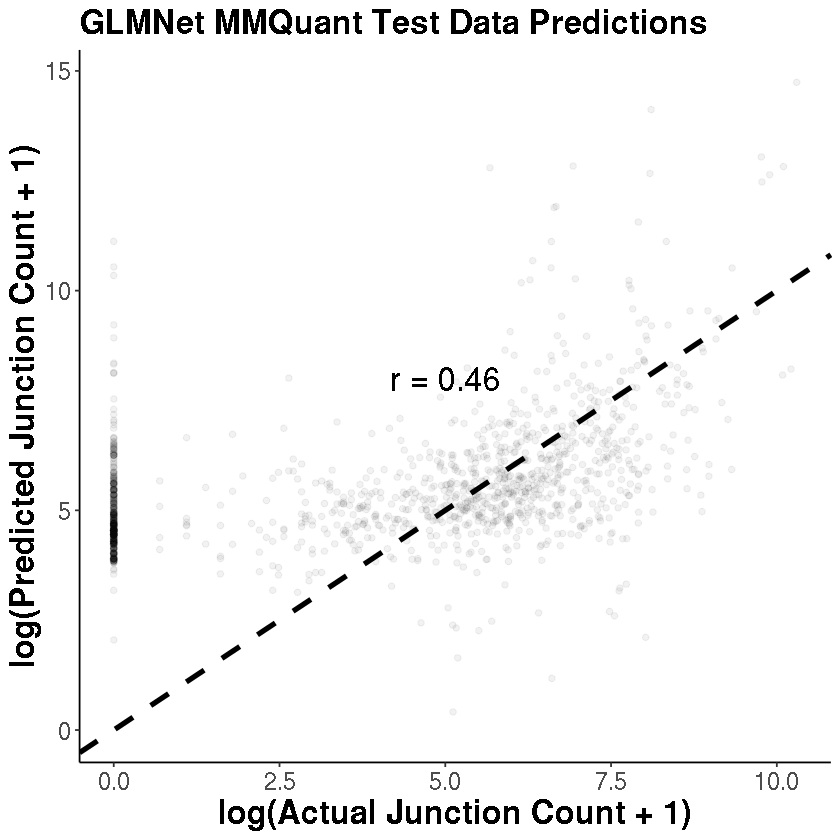

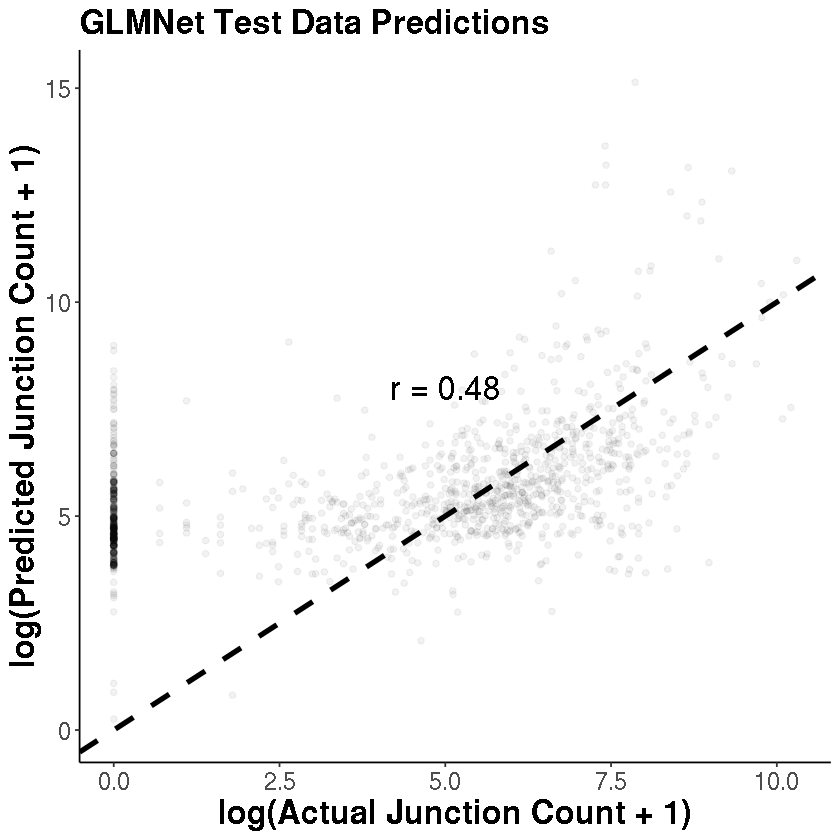

In [8]:
# plot predictions to actual counts for testing data
compare_predictions_plot(HTSeqPredOutputGLM[['testPreds']], testClassInputData[1:20, ], 'GLM HTSeq Test Data Predictions')
compare_predictions_plot(mmquantFilteredPredOutputGLM[['testPreds']], testClassInputData[1:20, ], 'GLM MMQuant Test Data Predictions')
compare_predictions_plot(mmquantCollapsedFilteredPredOutputGLM[['testPreds']], testClassInputData[1:20, ], 'GLM Test Data Predictions')
# compare_predictions_plot(mmquantCollapsedFilteredPredOutputGLM[['testPreds']], testClassInputData[1:20, ], 'GLM MMQuantCollapsed Test Data Predictions')

compare_predictions_plot(HTSeqPredOutputGLMNet[['testPreds']], testClassInputData[1:20, ], 'GLMNet HTSeq Test Data Predictions')
compare_predictions_plot(mmquantFilteredPredOutputGLMNet[['testPreds']], testClassInputData[1:20, ], 'GLMNet MMQuant Test Data Predictions')
compare_predictions_plot(mmquantCollapsedFilteredPredOutputGLMNet[['testPreds']], testClassInputData[1:20, ], 'GLMNet Test Data Predictions')
# compare_predictions_plot(mmquantCollapsedFilteredPredOutputGLMNet[['testPreds']], testClassInputData[1:20, ], 'GLMNet MMQuantCollapsed Test Data Predictions')

In [37]:
# collect all genes of each RNU class together for mmquant data

mmquantCollapsedGenes <- rownames(mmquantMatCollapsed)
RNUGenes <- mmquantCollapsedGenes[str_detect(mmquantCollapsedGenes, 'RNU')]
RNU1Genes <- mmquantCollapsedGenes[str_detect(mmquantCollapsedGenes, 'RNU1-')]
RNU2Genes <- mmquantCollapsedGenes[str_detect(mmquantCollapsedGenes, 'RNU2-')]
RNU3Genes <- mmquantCollapsedGenes[str_detect(mmquantCollapsedGenes, 'RNU3')]
RNU4Genes <- mmquantCollapsedGenes[str_detect(mmquantCollapsedGenes, 'RNU4-')]
RNU5Genes <- mmquantCollapsedGenes[str_detect(mmquantCollapsedGenes, 'RNU5')]
RNU6Genes <- mmquantCollapsedGenes[str_detect(mmquantCollapsedGenes, 'RNU6-')]
RNU4ATACGenes <- mmquantCollapsedGenes[str_detect(mmquantCollapsedGenes, 'RNU4ATAC')]
RNU6ATACGenes <- mmquantCollapsedGenes[str_detect(mmquantCollapsedGenes, 'RNU6ATAC')]

RNUGenesList <- list(RNU1Genes, RNU2Genes, RNU3Genes, RNU4Genes, RNU5Genes, RNU6Genes, 
                    RNU4ATACGenes, RNU6ATACGenes)
mmquantRNUMatCollapsedFiltered <- t(sapply(RNUGenesList, function(i) {
    # print(rownames(mmquantMatCollapsed) %in% i)
    return(colSums(mmquantMatCollapsed[rownames(mmquantMatCollapsed) %in% i, filtered.cells.subset]))
}))
rownames(mmquantRNUMatCollapsedFiltered) <- c('RNU1', 'RNU2', 'RNU3', 'RNU4', 'RNU5', 'RNU6', 'RNU4ATAC', 'RNU6ATAC')

Using rowname as id variables

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



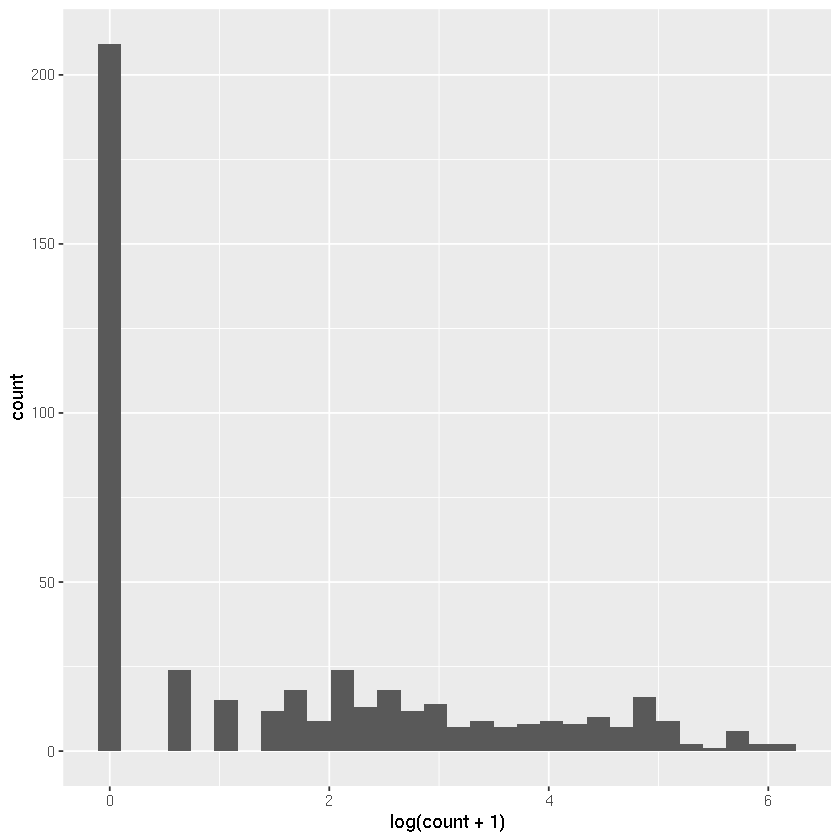

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



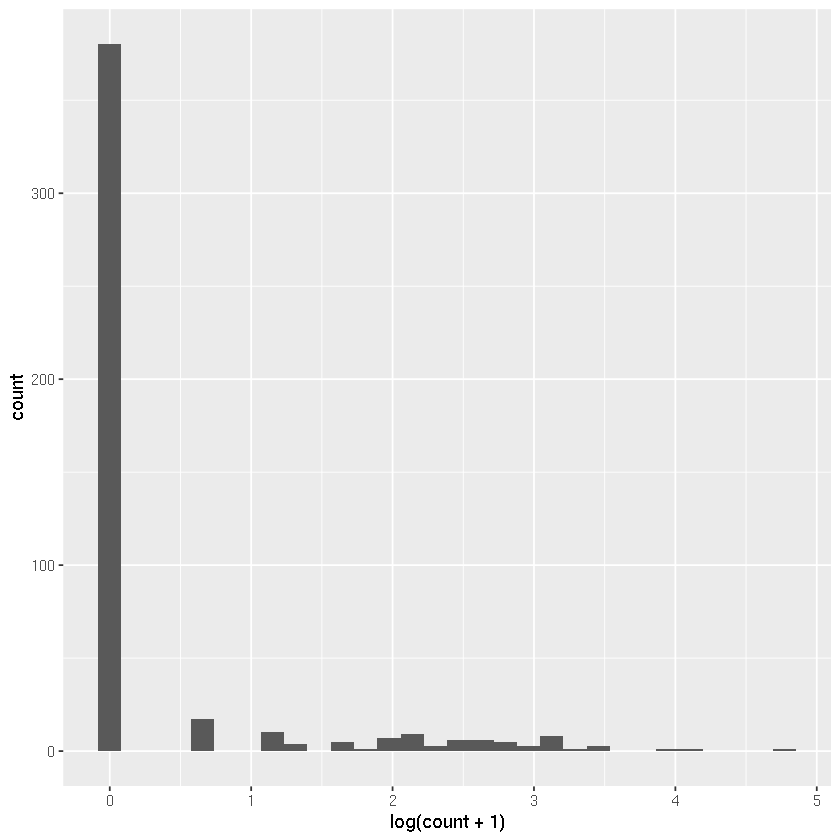

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



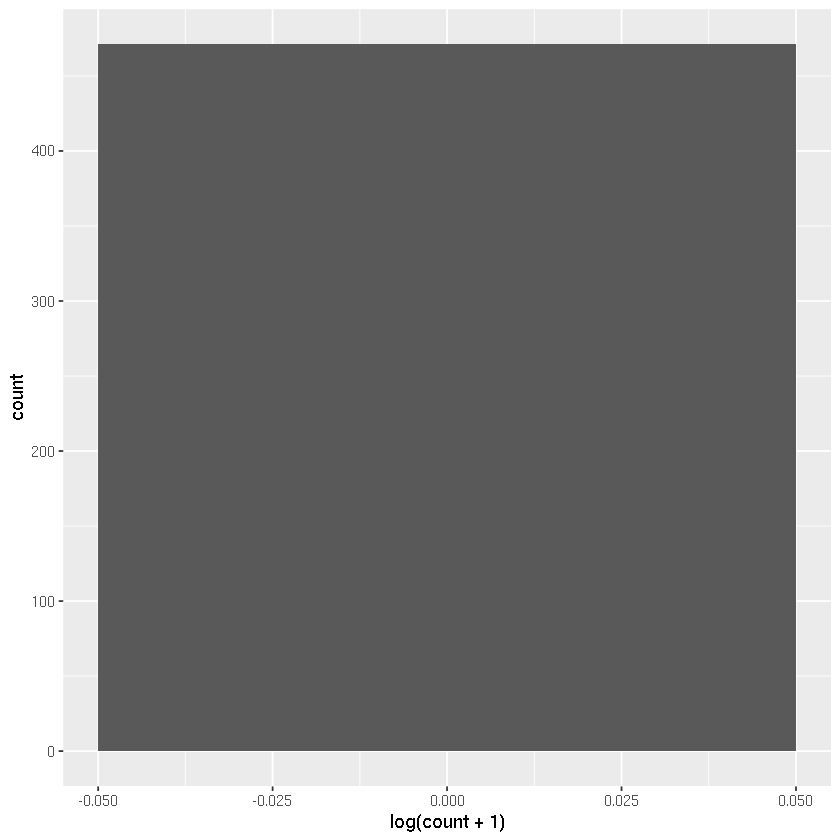

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



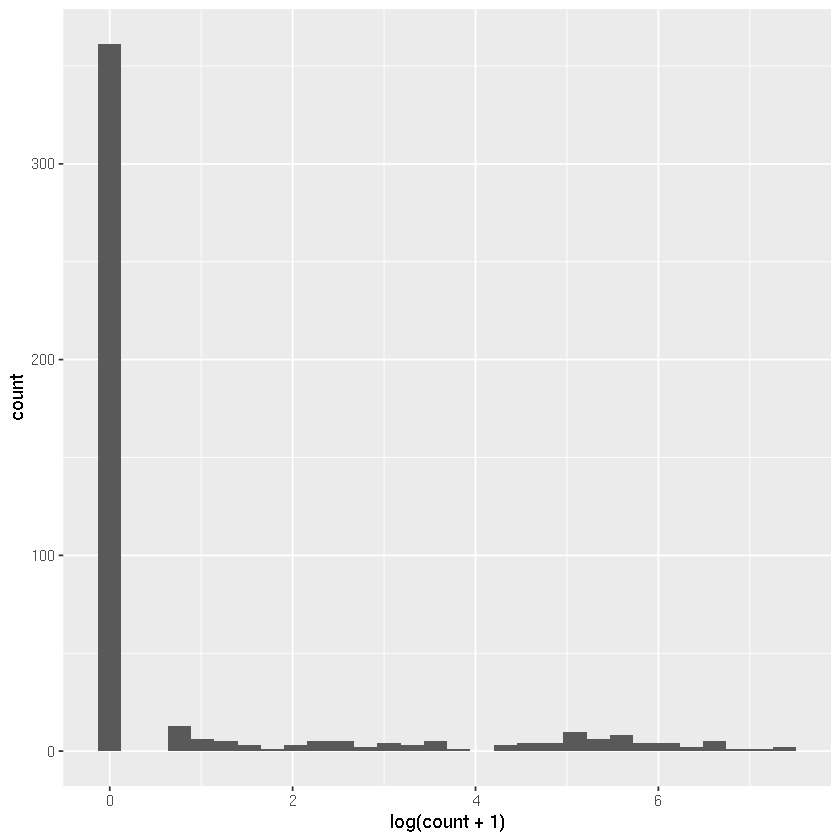

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



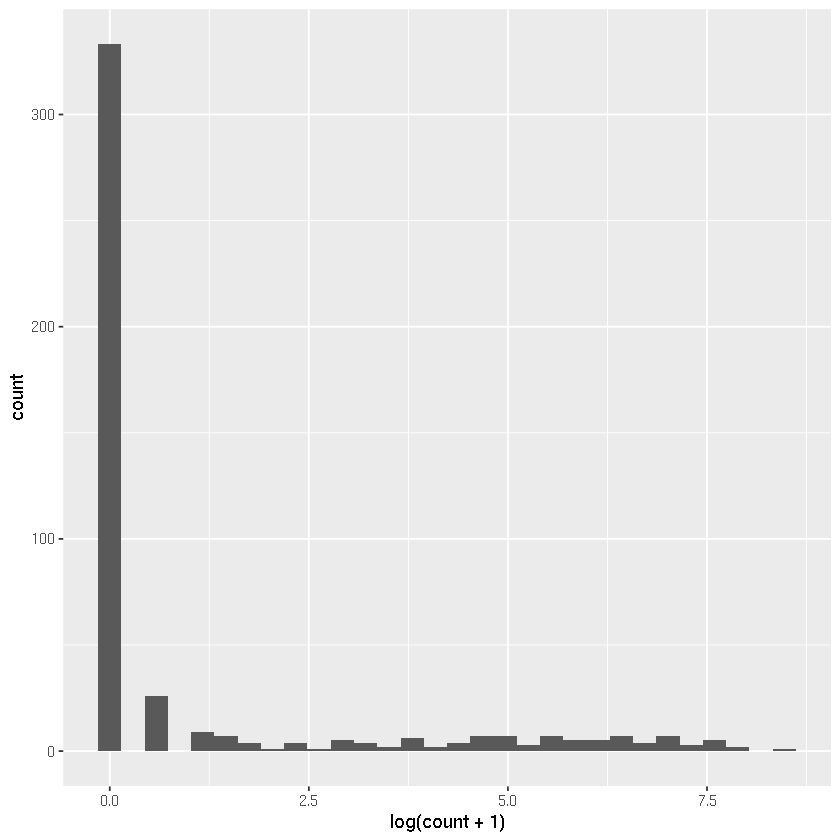

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



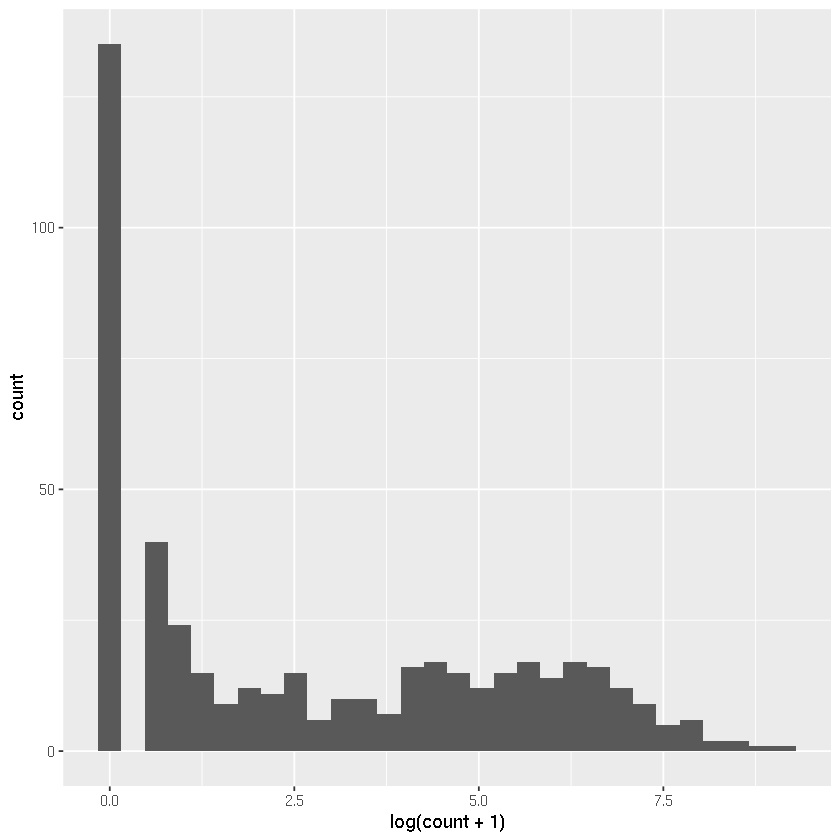

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



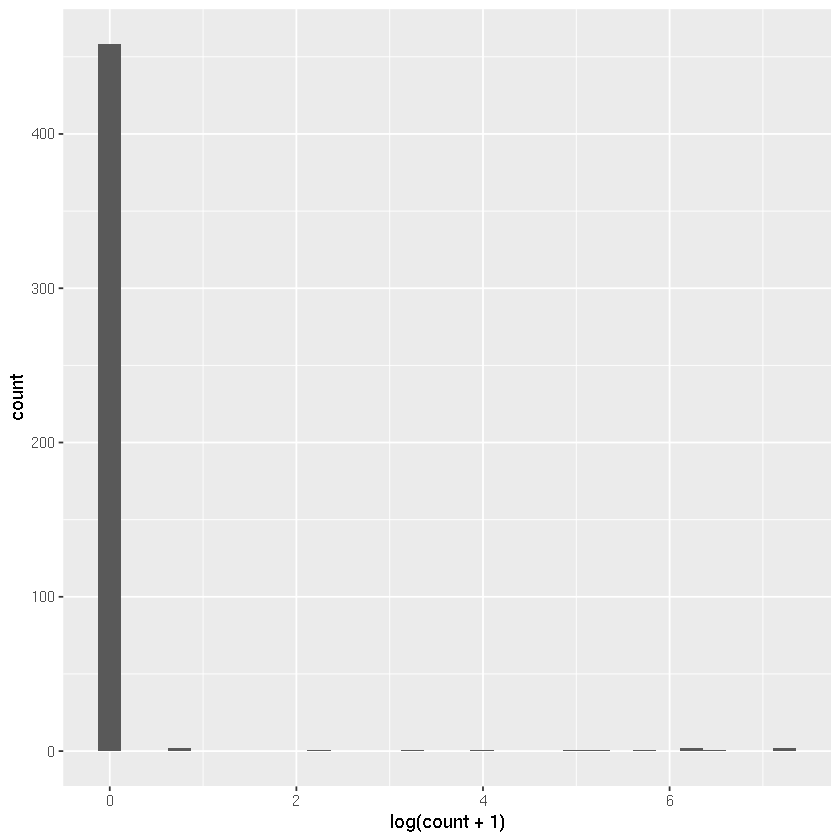

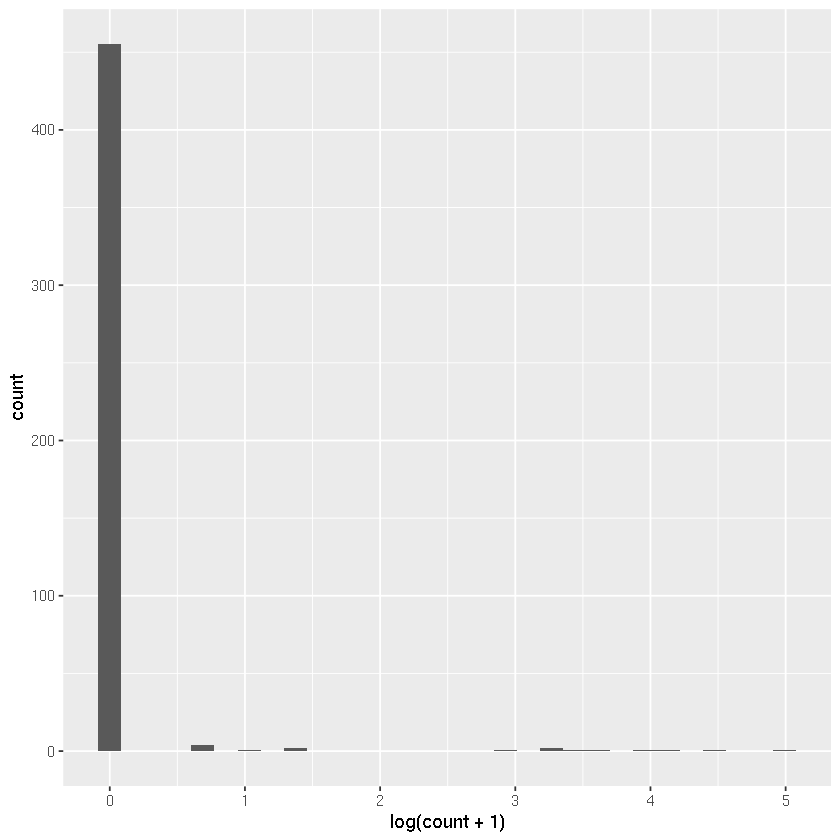

In [53]:
# plot detection of mmquant genes across all cells in the sample

mmquantRNUMatCollapsedFiltered <- as.data.frame(mmquantRNUMatCollapsedFiltered)
mmquantRNUMatCollapsedFilteredToGraph <- mmquantRNUMatCollapsedFiltered %>% rownames_to_column() %>% melt()

colnames(mmquantRNUMatCollapsedFilteredToGraph) <- c('RNU', 'Cell', 'count')
ggplot(subset(mmquantRNUMatCollapsedFilteredToGraph, RNU %in% 'RNU1'), aes(log(count + 1))) + geom_histogram()
ggplot(subset(mmquantRNUMatCollapsedFilteredToGraph, RNU %in% 'RNU2'), aes(log(count + 1))) + geom_histogram()
ggplot(subset(mmquantRNUMatCollapsedFilteredToGraph, RNU %in% 'RNU3'), aes(log(count + 1))) + geom_histogram()
ggplot(subset(mmquantRNUMatCollapsedFilteredToGraph, RNU %in% 'RNU4'), aes(log(count + 1))) + geom_histogram()
ggplot(subset(mmquantRNUMatCollapsedFilteredToGraph, RNU %in% 'RNU5'), aes(log(count + 1))) + geom_histogram()
ggplot(subset(mmquantRNUMatCollapsedFilteredToGraph, RNU %in% 'RNU6'), aes(log(count + 1))) + geom_histogram()
ggplot(subset(mmquantRNUMatCollapsedFilteredToGraph, RNU %in% 'RNU4ATAC'), aes(log(count + 1))) + geom_histogram()
ggplot(subset(mmquantRNUMatCollapsedFilteredToGraph, RNU %in% 'RNU6ATAC'), aes(log(count + 1))) + geom_histogram()

# (log(rowSums(mmquantRNUMatCollapsedFiltered) + 1))
# hist(log(colSums(mmquantRNUMatCollapsedFiltered)) + 1)

# (mmquantRNUMatCollapsed)

In [82]:
# check statistics for muscleblind-regulated genes
summary(t(read1Mat[str_detect(rownames(read1Mat), 'MBNL1'), ]))
rownames(read1Mat)[match('INSR', rownames(read1Mat))]
sum((read1Mat[str_detect(rownames(read1Mat), 'TNNT2'), ] > 0))
sum((read1Mat[match('INSR', rownames(read1Mat)), ] > 0))

     MBNL1          MBNL1-AS1       
 Min.   :   0.0   Min.   :  0.0000  
 1st Qu.:   0.0   1st Qu.:  0.0000  
 Median :   0.0   Median :  0.0000  
 Mean   : 115.1   Mean   :  0.6667  
 3rd Qu.:   7.0   3rd Qu.:  0.0000  
 Max.   :4162.0   Max.   :214.0000  

[1] "INSR"

[1] 5

[1] 110

In [94]:
# check INSR junction detection (since this is known to be regulated by muscleblind)
head(class.input.data.subset[str_detect('INSR', unlist(class.input.data.subset['acceptor'])), ])
sum(str_detect('INSR', unlist(class.input.data['acceptor'])))
head(class.input.data[str_detect('INSR', unlist(class.input.data['acceptor'])), ])

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


acceptor,donor,num_splice_events,N,B107809_A11_S131,B107809_A12_S132,B107809_A13_S133,B107809_A15_S135,B107809_A16_S136,B107809_A18_S138,⋯,B107811_C19_S265,B107811_C1_S247,B107811_C22_S268,B107811_C3_S249,B107811_C4_S250,B107811_D23_S292,B107817_H15_S244,B107827_C18_S202,B107830_F9_S176,B107921_N5_S272
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


[1] 0

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


acceptor,donor,num_splice_events,N,B107809_A11_S131,B107809_A12_S132,B107809_A13_S133,B107809_A15_S135,B107809_A16_S136,B107809_A18_S138,⋯,B107811_C19_S265,B107811_C1_S247,B107811_C22_S268,B107811_C3_S249,B107811_C4_S250,B107811_D23_S292,B107817_H15_S244,B107827_C18_S202,B107830_F9_S176,B107921_N5_S272
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [10]:
save.image('/scratch/PI/horence/jason/data/single_cell/influenza_russell/analyzed/R_analysis/TS_smartseq_gene_exp.RData')

In [ ]:
# spot check the expression of RNU4ATAC in the HTSeq-aligned data
colSums(read1Mat[, read1Mat['RNU4ATAC', ] > 0])

In [ ]:
test.cell.sam <- fread('/scratch/PI/horence/Roozbeh/single_cell_project/output/TS_pilot_smartseq_cSM_10_cJOM_10_aSJMN_0_cSRGM_0/B107809_J6_S33/1Aligned.out.sam', skip=459, header=FALSE, sep='\t')

In [ ]:
test.cell.sam.filtered <- test.cell.sam[as.vector(test.cell.sam[, 3] == 'chr2'), ]
test.cell.sam.filtered <- test.cell.sam.filtered[as.vector(test.cell.sam.filtered[, 4] > 121530880), ]
test.cell.sam.filtered <- test.cell.sam.filtered[as.vector(test.cell.sam.filtered[, 4] < 121531009), ]
# test.cell.sam.filtered <- test.cell.sam[as.vector(test.cell.sam[, 3] == 'chr2'), ]
test.cell.sam.filtered

In [ ]:
## write spot checks to file
write.table(test.cell.sam.filtered, file='/scratch/PI/horence/jason/data/tabula_sapiens/TS_smartseq_RNU4ATAC_check.tsv', quote=FALSE, sep='\t')

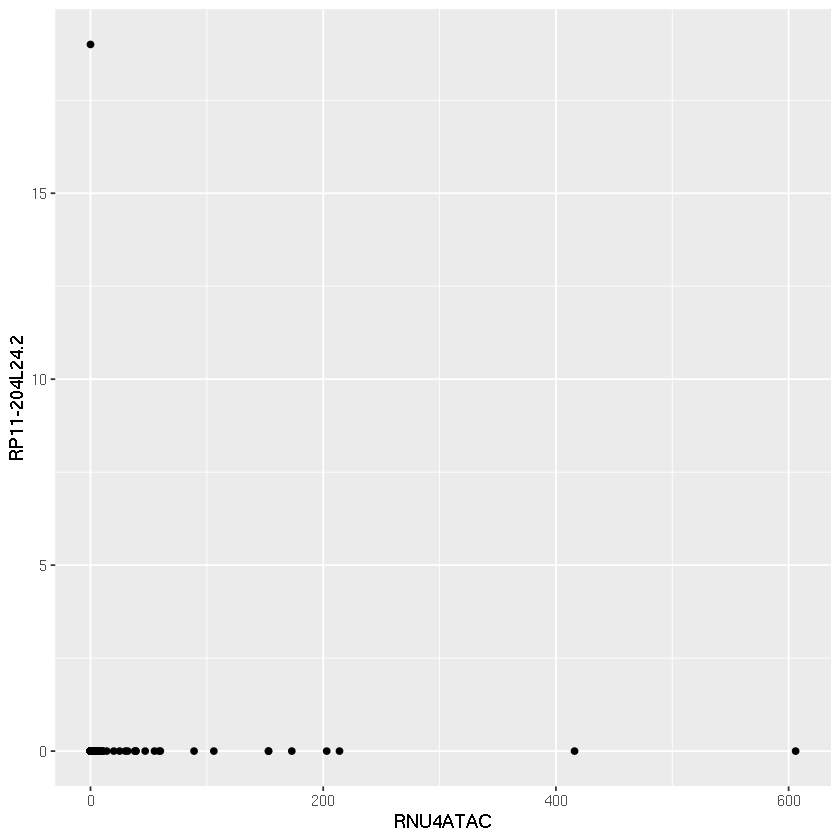

In [17]:
# plot(as.numeric(trainRead1MatData['RNU4ATAC', ]), as.numeric(trainRead1MatData['CLASP1', ]))
# str(as.data.frame(t(trainRead1MatData)))
ggplot(as.data.frame(t(trainRead1MatData)), aes(x=RNU4ATAC, y=`RP11-204L24.2`)) + geom_point()